In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))
from copy import deepcopy

import numpy as np
from condensate import Wavefunction, Environment

In [2]:
omega = 4

e = Environment(DIM=256, fov=0.56e-3, N=2e7)

e.harmonic_potential(omega=omega)


            Running condensate on 256x256 grid with:
            atom number: 2e+07 
            mass:        3.80e-26
        


In [3]:
wf = Wavefunction(e)
wf.initialize_Psi(width=100, vortexnumber=0)

In [4]:
wf.relax(dt=2e-3, steps=5000, vmax=3e7)

In [5]:
e.edge =  {'on': True, 'strength': .1, 'radius': 220e-6, 'width': 7e-6}
e.harmonic_potential(omega=0.01*omega)

In [6]:
wf.env.lab_frame()
wf.relax(dt=3e-3, steps=5000, vmax=1.2e7)

In [7]:
# e.spoon['type']='mouse'
# wf.evolve(dt=1e-3, steps=0, vmax=1.2e7, cooling=0.01)

In [10]:
def add_vortices(Psi, env, vortices):
    DIM = env.DIM
    x = (1+0.j)*np.zeros((DIM,DIM))
    for i in range(DIM):
        for j in range(DIM):
            phase = 1
            for v in vortices:
                sign = 1 if len(v)==2 else v[2]
                phi =  np.arctan2((i-v[1]-DIM//2), (j-v[0]-DIM//2))
                phase =  np.exp(sign *1.j * np.mod(phi,2*np.pi))
                Psi[i,j] *= phase
    return Psi

In [15]:
vortices = [[-50,0,1],[50,0,1]]
# vortices = [[i,0,1] for i in range(-60,60,20)]
wf.Psi = add_vortices(wf.Psi, e, vortices)
wf.relax(dt=3e-3, steps=300, vmax=1.2e7)

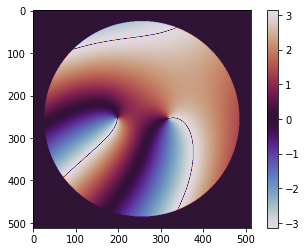

In [16]:
wf.show_phase()

In [7]:
start = deepcopy(wf)

### Make gyros

In [33]:
wf = deepcopy(start)

In [30]:
sep = 18
vortices = [[-sep,0,1],[sep,0,-1]]
wf.Psi = add_vortices(wf.Psi, e, vortices)
wf.relax(dt=2e-3, steps=30, vmax=1.2e7)
wf.relax(dt=2e-3, steps=300, vmax=1.2e7)

In [31]:
wf.env.rotating_frame(omegaR=[0.01])
wf.evolve(dt=3e-4, steps=0, vmax=1.2e7, cooling=0.005, showevery=100)

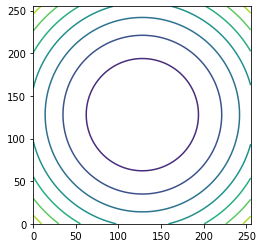

In [34]:
wf.env.show_potential()

### noisy edge

In [5]:
DIM, fov = wf.env.DIM, wf.env.fov

def edge_harmonic(sigma, separation, amp=500, single=False):
    V = np.zeros((DIM,DIM))
    for i in range(DIM):
        for j in range(DIM):
            x = (i-DIM//2)*fov / DIM
            y = (j-DIM//2)*fov / DIM
            spot1 = (1-np.exp(-(x**2+ (y-separation/2)**2)/sigma**2))
            spot2 = (not single) * (1-np.exp(-(x**2+ (y+separation/2)**2)/sigma**2))
            V[i,j] = amp*((spot1+spot2)-1)
    return V